In [1]:
import torch
import numpy as np
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),lambda x: x * 255])
mnist_train = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)
mnist_test = datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transform, 
    download=True
)
labels = mnist_train.targets

In [3]:
train_loader = DataLoader(mnist_train,batch_size = 64,shuffle = True)
test_loader = DataLoader(mnist_test,batch_size = 64,shuffle = True)

In [4]:
from torch.utils.data import Dataset
class mnistNoised(Dataset):
    def __init__(self, train):
        if(train == 1):
            self.x = mnist_train
        else:
            self.x = mnist_test
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx][0]
        awgn = torch.normal(0.0, 97.0, image.shape)
        return image, torch.clamp(image + awgn, 0.0, 255.0)

In [5]:
mnist_noised_train = mnistNoised(train = 1)
train_noised = DataLoader(mnist_noised_train,batch_size = 64, shuffle = True)
mnist_noised_test = mnistNoised(train = 0)
test_noised = DataLoader(mnist_noised_test,batch_size = 64, shuffle = True)

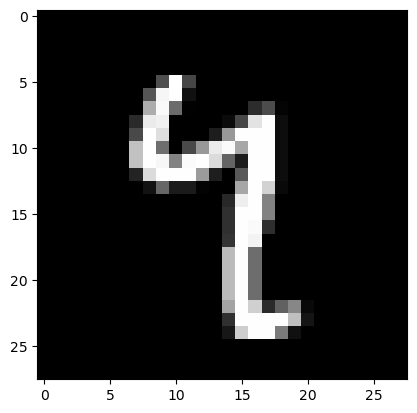

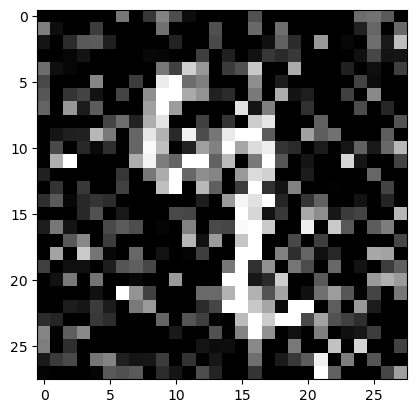

In [6]:
for original, noised in train_noised:
    plt.imshow(original[0][0], cmap = 'gray')
    plt.show()
    plt.imshow(noised[0][0], cmap = 'gray')
    plt.show()
    break

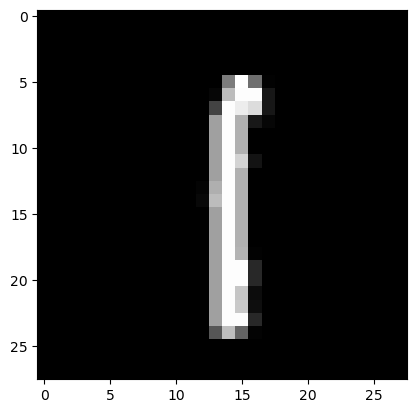

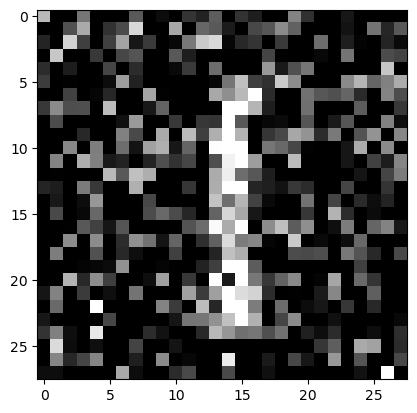

In [7]:
for original, noised in test_noised:
    plt.imshow(original[0][0], cmap = 'gray')
    plt.show()
    plt.imshow(noised[0][0], cmap = 'gray')
    plt.show()
    break

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3),
            nn.ReLU()
        )
        self.bottleneck_dims = []
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    for img, noised_img in train_noised:
        optimizer.zero_grad()
        output = autoencoder(noised_img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/15], Loss: 758.10595703125
Epoch [2/15], Loss: 690.2874755859375
Epoch [3/15], Loss: 584.358154296875
Epoch [4/15], Loss: 624.3123168945312
Epoch [5/15], Loss: 573.3524169921875
Epoch [6/15], Loss: 566.3436889648438
Epoch [7/15], Loss: 576.7933349609375
Epoch [8/15], Loss: 637.94189453125
Epoch [9/15], Loss: 536.1969604492188
Epoch [10/15], Loss: 601.1451416015625
Epoch [11/15], Loss: 547.0460205078125
Epoch [12/15], Loss: 571.1998901367188
Epoch [13/15], Loss: 594.6046752929688
Epoch [14/15], Loss: 553.3582763671875
Epoch [15/15], Loss: 613.9876708984375


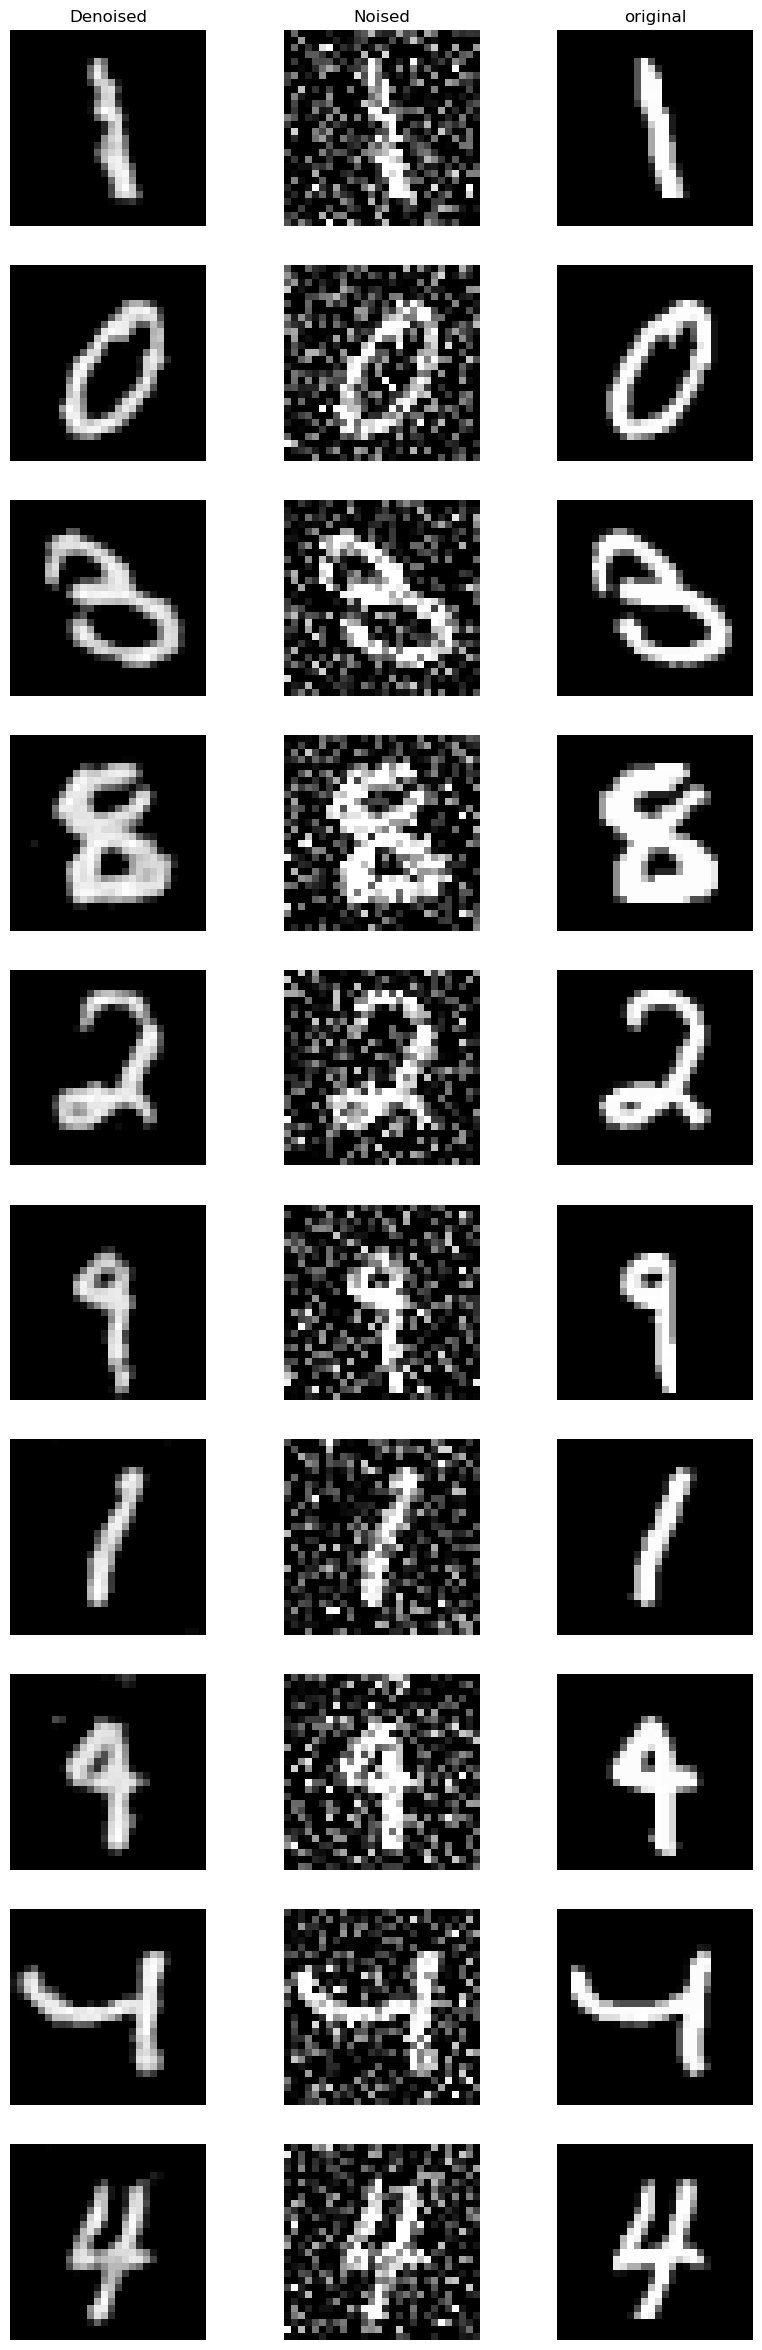

In [10]:
fig, axs = plt.subplots(10,3,figsize=(10, 30))
shuffled_indices = torch.randperm(len(mnist_noised_test))
image = [mnist_noised_test[indice][1] for indice in shuffled_indices[:10]]
original = [mnist_noised_test[indice][0] for indice in shuffled_indices[:10]]
with torch.no_grad():
    for idx in range(10):
        output = autoencoder(image[idx])
        axs[idx,0].imshow(output[0],cmap = 'gray')
        axs[idx,1].imshow(image[idx][0],cmap = 'gray')
        axs[idx,2].imshow(original[idx][0],cmap = 'gray')
        if(idx == 0):
            axs[idx,2].set_title("original")
            axs[idx,0].set_title("Denoised")
            axs[idx,1].set_title("Noised")
            
        axs[idx,2].axis('off')
        axs[idx,0].axis('off')
        axs[idx,1].axis('off')